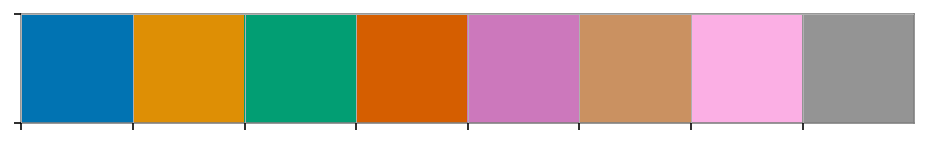

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
#import matplotlib.pyplot as P

golden_ratio = 1.61803398875
matplotlib.rcParams['figure.figsize'] = (10, 10/golden_ratio)

import gwsurrogate

from tqdm import tqdm

from bilby.core.utils import nfft, infft

from scipy import interpolate
import scipy.integrate as integrate
from scipy import stats
from scipy.signal.windows import tukey
from scipy.stats import truncnorm, norm
from scipy.interpolate import interp1d

import lal

import numexpr as ne
#import pyfftw

import seaborn as sns

cp = sns.color_palette('colorblind', 8)
sns.palplot(cp)
plt.show()

from gwtools import gwutils as gwu

In [3]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
trunc_sur = gwsurrogate.LoadSurrogate('/home/carl-johan.haster/projects/Waveform_marginalisation/TruncatedSurrogate/NRHybSur3dq8.h5')

/home/carl-johan.haster/.conda/envs/WF_marg_igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/saveH5Object.py:106: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  v = item.value


Loaded NRHybSur3dq8 model
Loaded NRHybSur3dq8 model


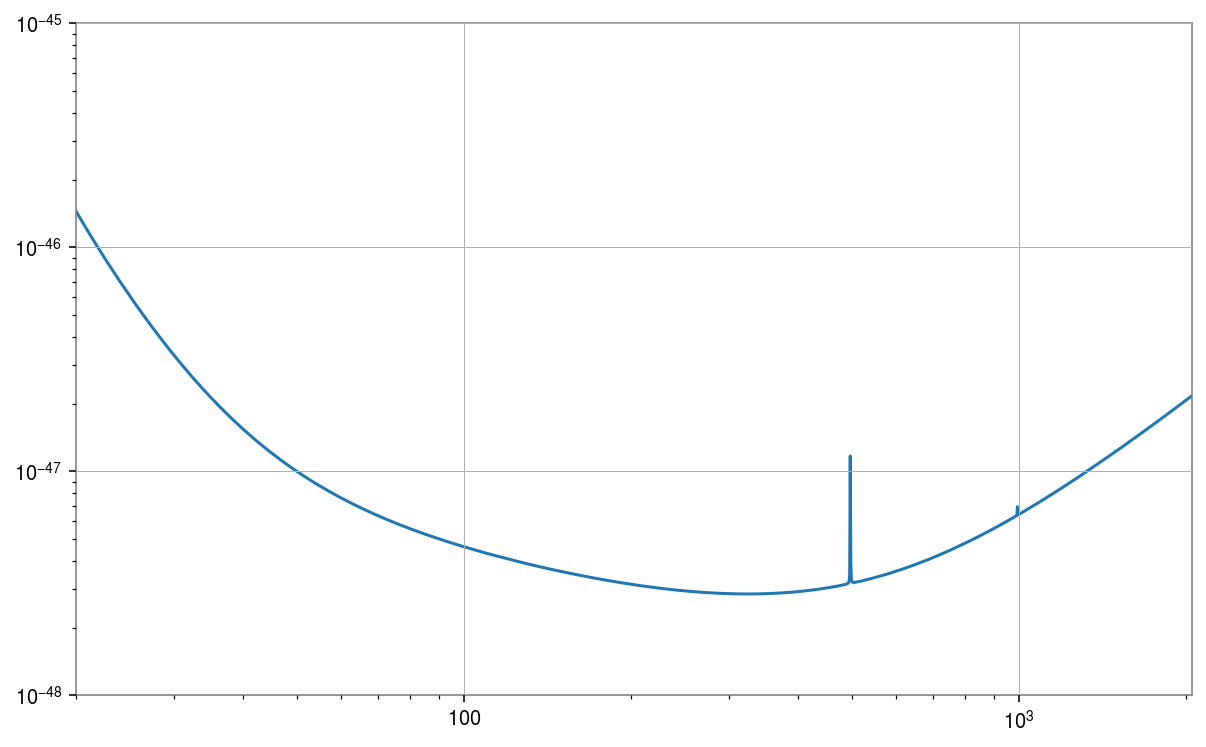

In [5]:
Aplus_asd = np.genfromtxt('/home/carl-johan.haster/projects/Waveform_marginalisation/Injection_data/PSDs/AplusDesign_filledIn.txt')

plt.loglog(Aplus_asd[:,0], np.square(Aplus_asd[:,1]))
plt.xlim(20, 2048)
plt.ylim(1e-48, 1e-45)
plt.show()

In [7]:
def uniform_in_cos_angle(N,costheta_min=-1, costheta_max=1, offset=0.):
    return np.arccos(np.random.uniform(costheta_min,costheta_max,N)) + offset

def uniform_in_angle(N,theta_min=0., theta_max=2.*np.pi, offset=0.):
    return np.random.uniform(theta_min,theta_max,N) + offset

def innprod(h1, h2, freq, Sn):
    #print(h1.shape, h2.shape, freq.shape, Sn.shape)
    over = ne.evaluate('h1*complex(h2.real, -h2.imag)/Sn')
    integral = integrate.simps(over, freq)
    return 4.*integral.real

def innprod_max(h1, h2, freq, Sn):
    dot1 = ne.evaluate('h1*complex(h2.real, -h2.imag)/Sn')
    dot2 = ne.evaluate('complex(0,1)*dot1')	#used to be ne.evaluate('complex(0,-1)*dot1'),  I'm changing the direction of rotation
    #dot1_al = pyfftw.n_byte_align(dot1, 16, 'complex128')
    #dot2_al = pyfftw.n_byte_align(dot2, 16, 'complex128')
    #transform1 = pyfftw.interfaces.numpy_fft.irfft(dot1_al)
    transform1 = np.fft.irfft(dot1)
    #transform2 = pyfftw.interfaces.numpy_fft.irfft(dot2_al)
    transform2 = np.fft.irfft(dot2)
    #wisdom = pyfftw.export_wisdom()
    transform = ne.evaluate('sqrt((transform1**2) + (transform2**2))')
    #dt=1./(max(freq))
    dt = 1./(2.*freq[-1])	#check that this is true!
    transform_0 = transform.max()

    if transform.argmax() == transform.size - 1:
        transform_p = transform[0]
        transform_m = transform[transform.argmax() - 1]
    elif transform.argmax()==0:
        transform_p = transform[transform.argmax() + 1]
        transform_m = transform[-1]
    else:
        transform_p=transform[transform.argmax()+1]
        transform_m=transform[transform.argmax()-1]
    
    t_peak = -dt*(transform_p - transform_m)/(2*transform_p+2*transform_m - 4*transform_0)		#check this analytically!
    transform_max= transform_0  + t_peak*(transform_p - transform_m)/(2*dt) + t_peak**2. * (0.5*transform_p + 0.5*transform_p - transform_0)/(dt**2)
    return 4*transform_max*(freq[-1] - freq[0])

def find_nearest_indices(values, array):
        return np.absolute(np.subtract.outer(array, values)).argmin(0)

def NRHybSur3dq8_marg_InnerProduct(times, total_mass, mass_ratio, chi_1, chi_2, luminosity_distance, theta_jn, phase, \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., \
                                   phaseScatterSigma = 1., ampScatterSigma = 1/10., Nextrinsic=100, TimePhaseMax=True, \
                                   printInnerProds=False, NumPointStep=100, plotStuff=False, OnlyPlotPlanck=False, PlotFinalPol=False, ScatterVersion='v1'):
        #set up the waveform arguments
        if plotStuff and not OnlyPlotPlanck:
            OnlyPlotPlanck = True
        #reference_frequency = kwargs['reference_frequency']
        dt = 1./sampling_frequency
        ellMax = None
        #minimum_frequency = kwargs['minimum_frequency']

        #convert parameters
        q = 1./mass_ratio
        # q is > 1, whereas mass_ratio is < 1
        spin1 = [0., 0., chi_1]
        spin2 = [0., 0., chi_2]

        #evaluate waveform
        t, h, dyn = sur(q, spin1, spin2, dt=dt, f_low=minimum_frequency, f_ref=reference_frequency,
                        ellMax=ellMax, dist_mpc=luminosity_distance, M=total_mass,
                        inclination=theta_jn, phi_ref=phase, units='mks')
        
        t_trunc, h_trunc, dyn_trunc = trunc_sur(q, spin1, spin2, dt=dt, f_low=minimum_frequency, f_ref=reference_frequency,
                ellMax=ellMax, dist_mpc=luminosity_distance, M=total_mass,
                inclination=theta_jn, phi_ref=phase, units='mks')

        if len(h.real) > len(h_trunc.real):
                h_plus_diff = h.real[len(h.real) - len(h_trunc.real):] - h_trunc.real
                h_cross_diff = -h.imag[len(h.imag) - len(h_trunc.imag):] + h_trunc.imag
                
                h_plus_full = h.real[len(h.real) - len(h_trunc.real):]
                h_cross_full = -h.imag[len(h.imag) - len(h_trunc.imag):]
                t_full = t[len(h.imag) - len(h_trunc.imag):]
                
        elif len(h.real) < len(h_trunc.real):
                h_plus_diff = np.pad(h.real, (len(h_trunc.real) - len(h.real), 0), 'constant', constant_values=0.) - h_trunc.real
                h_cross_diff = np.pad(-h.imag, (len(h_trunc.imag) - len(h.imag), 0), 'constant', constant_values=0.) + h_trunc.imag
                
                h_plus_full = np.pad(h.real, (len(h_trunc.real) - len(h.real), 0), 'constant', constant_values=0.)
                h_cross_full = np.pad(-h.imag, (len(h_trunc.imag) - len(h.imag), 0), 'constant', constant_values=0.)
                t_full = np.pad(t, (len(h_trunc.imag) - len(h.imag), 0), 'constant', constant_values=0.)
        else:
                h_plus_diff = h.real - h_trunc.real
                h_cross_diff = -h.imag + h_trunc.imag
                h_plus_full = h.real
                h_cross_full = -h.imag
                t_full = t

        if plotStuff:
            print('plot first full WF')
            plt.plot(t_full, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(t_full, h_cross_full, label='h_cross_full', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
            print('plot first WF diff')
            plt.plot(t_full, h_plus_diff, label='h_plus_diff', lw=2, alpha=0.7)
            plt.plot(t_full, h_cross_diff, label='h_cross_diff', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        
        h_plus_diff_fft, h_plus_diff_freq = nfft(h_plus_diff, sampling_frequency=1./dt)
        #print(h_plus_diff_freq.shape, h_plus_diff_freq)
        Raw_diff_plus_amp = np.absolute(h_plus_diff_fft)
        Raw_diff_plus_phase = np.unwrap(np.angle(h_plus_diff_fft))

        h_cross_diff_fft, h_cross_diff_freq = nfft(h_cross_diff, sampling_frequency=1./dt)
        Raw_diff_cross_amp = np.absolute(h_cross_diff_fft)
        Raw_diff_cross_phase = np.unwrap(np.angle(h_cross_diff_fft))

        Num_Select_raw = int(len(h_plus_diff)/NumPointStep)
        f_select_array = np.logspace(np.log10(h_plus_diff_freq[1]), np.log10(h_plus_diff_freq[-1]), Num_Select_raw)
        f_select_array_indeces_raw = find_nearest_indices(f_select_array, h_plus_diff_freq)
        f_select_array_indeces = np.array(list(dict.fromkeys(f_select_array_indeces_raw.tolist())))
        Num_Select = len(f_select_array_indeces)
        
        if ScatterVersion == 'v1':

            Amp_mean_plus = Raw_diff_plus_amp[f_select_array_indeces]
            Amp_std_plus = Raw_diff_plus_amp[f_select_array_indeces]*ampScatterSigma
            Phase_mean_plus = Raw_diff_plus_phase[f_select_array_indeces]
            Phase_std_plus = np.ones(Num_Select)*phaseScatterSigma

            Amp_mean_cross = Raw_diff_cross_amp[f_select_array_indeces]
            Amp_std_cross = Raw_diff_cross_amp[f_select_array_indeces]*ampScatterSigma
            Phase_mean_cross = Raw_diff_cross_phase[f_select_array_indeces]
            Phase_std_cross = np.ones(Num_Select)*phaseScatterSigma
            
        elif ScatterVersion == 'v2':
            Amp_mean_plus = 0.
            Amp_std_plus = Raw_diff_plus_amp[f_select_array_indeces]
            Phase_mean_plus = 0.
            Phase_std_plus = Raw_diff_plus_phase[f_select_array_indeces]

        Amp_Gauss_plus = np.zeros(Num_Select)
        Phase_Gauss_plus = np.zeros(Num_Select)
        Amp_Gauss_cross = np.zeros(Num_Select)
        Phase_Gauss_cross = np.zeros(Num_Select)
        
        for i in range(Num_Select):
            low_plus, high_plus = 0., 5*Amp_mean_plus[i]
            low_a_plus = (low_plus-Amp_mean_plus[i])/Amp_std_plus[i]
            high_b_plus = (high_plus-Amp_mean_plus[i])/Amp_std_plus[i]
            Amp_Gauss_plus[i] = truncnorm.rvs(a=low_a_plus, b=high_b_plus, loc = Amp_mean_plus[i], scale=Amp_std_plus[i], size=1)
            Phase_Gauss_plus[i] = norm.rvs(loc = Phase_mean_plus[i], scale=Phase_std_plus[i], size=1)

            low_cross, high_cross = 0., 5*Amp_mean_cross[i]
            low_a_cross = (low_plus-Amp_mean_cross[i])/Amp_std_cross[i]
            high_b_cross = (high_plus-Amp_mean_cross[i])/Amp_std_cross[i]
            Amp_Gauss_cross[i] = truncnorm.rvs(a=low_a_cross, b=high_b_cross, loc = Amp_mean_cross[i], scale=Amp_std_cross[i], size=1)
            Phase_Gauss_cross[i] = norm.rvs(loc = Phase_mean_cross[i], scale=Phase_std_cross[i], size=1)

        Amp_plus_interpolant = interp1d(h_plus_diff_freq[f_select_array_indeces], Amp_Gauss_plus, \
                kind='cubic', bounds_error=False, fill_value = 0.)
        Phase_plus_interpolant = interp1d(h_plus_diff_freq[f_select_array_indeces], Phase_Gauss_plus, \
                kind='cubic', bounds_error=False, fill_value = 0.)
        Freq_domain_diff_plus = Amp_plus_interpolant(h_plus_diff_freq)*np.exp(1j*Phase_plus_interpolant(h_plus_diff_freq))
        Time_domain_diff_plus = infft(frequency_domain_strain=Freq_domain_diff_plus, sampling_frequency=1/dt)
        if len(Time_domain_diff_plus) > len(h_trunc.real):
                Time_domain_diff_plus = Time_domain_diff_plus[:len(h_trunc.real)]
        elif len(Time_domain_diff_plus) < len(h_trunc.real):
                Time_domain_diff_plus = np.pad(Time_domain_diff_plus, (len(h_trunc.real) - len(Time_domain_diff_plus), 0), 'constant')

        Amp_cross_interpolant = interp1d(h_plus_diff_freq[f_select_array_indeces], Amp_Gauss_cross, \
                kind='cubic', bounds_error=False, fill_value = 0.)
        Phase_cross_interpolant = interp1d(h_plus_diff_freq[f_select_array_indeces], Phase_Gauss_cross, \
                kind='cubic', bounds_error=False, fill_value = 0.)
        Freq_domain_diff_cross = Amp_cross_interpolant(h_plus_diff_freq)*np.exp(1j*Phase_cross_interpolant(h_plus_diff_freq))
        Time_domain_diff_cross = infft(frequency_domain_strain=Freq_domain_diff_cross, sampling_frequency=1/dt)
        if len(Time_domain_diff_cross) > len(h_trunc.imag):
                Time_domain_diff_cross = Time_domain_diff_cross[:len(h_trunc.imag)]
        elif len(Time_domain_diff_cross) < len(h_trunc.imag):
                Time_domain_diff_cross = np.pad(Time_domain_diff_cross, (len(h_trunc.imag) - len(Time_domain_diff_cross), 0), 'constant')

        h_plus_nonPlancked = h_trunc.real + Time_domain_diff_plus
        h_cross_nonPlancked = -1*h_trunc.imag + Time_domain_diff_cross

        
        if plotStuff:
            print('plot raw pol, after scatter hsa been applied')
            plt.plot(h_plus_nonPlancked, label='h_plus_nonPlancked', lw=2, alpha=0.7)
            plt.plot(h_cross_nonPlancked, label='h_cross_nonPlancked', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        if plotStuff:
            print(' with and without scatter')
            plt.plot(t_full, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(t_full, h_plus_nonPlancked, label='h_plus_nonPlancked', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
            
        SixtyM = 60.*lal.MTSUN_SI*total_mass
        OneThirtyM = 130.*lal.MTSUN_SI*total_mass
        
        #FiftyM = 50.*lal.MTSUN_SI*total_mass
        #EightyM = 80.*lal.MTSUN_SI*total_mass
        
        FortyM = 40.*lal.MTSUN_SI*total_mass
        SeventyM = 70.*lal.MTSUN_SI*total_mass
        
        beginning_window_duration = 0.05
        
        #h_plus = gwu.windowWaveform(t_trunc, h_plus_nonPlancked, t_trunc[0], t_trunc[0]+0.1, FortyM, SeventyM, windowType="planck")
        #h_cross = gwu.windowWaveform(t_trunc, h_cross_nonPlancked, t_trunc[0], t_trunc[0]+0.1, FortyM, SeventyM, windowType="planck")
        h_plus = gwu.windowWaveform(t_trunc, h_plus_nonPlancked, t_trunc[0], t_trunc[0]+beginning_window_duration, SixtyM, OneThirtyM, windowType="planck")
        h_cross = gwu.windowWaveform(t_trunc, h_cross_nonPlancked, t_trunc[0], t_trunc[0]+beginning_window_duration, SixtyM, OneThirtyM, windowType="planck")
        
        if OnlyPlotPlanck:
            print(' with and without Plancking')
            plt.plot(t_full, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(t_trunc, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.plot(t_trunc, h_plus_nonPlancked, label='h_plus_nonPlancked', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
            
            print(' with and without Plancking bbeginning')
            plt.plot(t_full, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(t_trunc, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.plot(t_trunc, h_plus_nonPlancked, label='h_plus_nonPlancked', lw=2, alpha=0.7)
            plt.xlim(t_trunc[0], t_trunc[0]+0.15)
            plt.axvline(t_trunc[0]+0.1, label='0.1')
            plt.legend(handlelength=20)
            plt.show()
            
            print(' with and without Plancking end')
            plt.plot(t_full, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(t_trunc, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.plot(t_trunc, h_plus_nonPlancked, label='h_plus_nonPlancked', lw=2, alpha=0.7)
            plt.xlim(t_trunc[-1]-0.05, t_trunc[-1])
            #plt.axvline(FortyM, label='40 M', ls='--')
            #plt.axvline(SeventyM, label='70 M', ls=':')
            plt.axvline(SixtyM, label='60 M', ls='--')
            plt.axvline(OneThirtyM, label='130 M', ls=':')
             
            plt.legend(handlelength=20)
            plt.show()
        

        diff = len(times) - len(t_trunc)
        
        
        
        if diff > 0:
                # if the waveform is shorter, zero pad to end
                h_plus = np.pad(h_plus, (0, diff), 'constant')
                h_cross = np.pad(h_cross, (0, diff), 'constant')
        elif diff < 0:
                # if the waveform is longer, remove from inspiral
                h_plus = h_plus[-diff:]
                h_cross = h_cross[-diff:]
                t_trunc = t_trunc[-diff:]
                
        if plotStuff:
            print('plot padded or timeTrunc WF')
            plt.plot(times, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.plot(times, h_cross, label='h_cross', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        #else:
        #    t = t[-diff:]
        #if MargSurr:
        #        ind_t0 = np.where(t_trunc>=0)[0][0]
        #else:
        ind_t0 = np.where(t_trunc>=0)[0][0]
        
        #timeshift peak to beginning of segment
        h_plus = np.roll(h_plus, len(h_plus)-ind_t0)
        h_cross = np.roll(h_cross, len(h_cross)-ind_t0)
        
        if plotStuff:
            print('plot timeshifted WF')
            plt.plot(times, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.plot(times, h_cross, label='h_cross', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
                
        #tukey window the padded waveform
        ##duration = len(times)*dt
        ##alpha = 2*0.2/duration #rise time of window is 0.2s
        ##middle = int(len(times)/2)
        ##window = tukey(len(times), alpha)
        ##window[middle:] = 1 #only window the inspiral
        
        ##h_plus *=window
        ##h_cross *= window
        
        if plotStuff:
            print('plot windowed WF')
            plt.plot(times, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.plot(times, h_cross, label='h_cross', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        
        #h_plus_full = gwu.windowWaveform(t_full, h_plus_full, t_full[0], t_full[0]+0.1, FortyM, SeventyM, windowType="planck")
        #h_cross_full = gwu.windowWaveform(t_full, h_cross_full, t_full[0], t_full[0]+0.1, FortyM, SeventyM, windowType="planck")
        h_plus_full  = gwu.windowWaveform(t_full, h_plus_full, t_trunc[0], t_trunc[0]+beginning_window_duration, SixtyM, OneThirtyM, windowType="planck")
        h_cross_full = gwu.windowWaveform(t_full, h_cross_full, t_full[0], t_full[0]+beginning_window_duration, SixtyM, OneThirtyM, windowType="planck")
        
        
        diff_full = len(times) - len(t_full)
        
        if diff_full > 0:
                # if the waveform is shorter, zero pad to end
                h_plus_full = np.pad(h_plus_full, (0, diff_full), 'constant')
                h_cross_full = np.pad(h_cross_full, (0, diff_full), 'constant')
        elif diff_full < 0:
                # if the waveform is longer, remove from inspiral
                h_plus_full = h_plus_full[-diff_full:]
                h_cross_full = h_cross_full[-diff_full:]
                t_full = t_full[-diff_full:]
        
        if plotStuff:
            print('plot padded or timeTrunc FullWF')
            plt.plot(times, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(times, h_cross_full, label='h_cross_full', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        
        ind_t0_full = np.where(t_full>=0)[0][0]
        
        #print(len(times), len(t_full), len(t_trunc))
        

        
        #timeshift peak to beginning of segment
        h_plus_full = np.roll(h_plus_full, len(h_plus_full)-ind_t0_full)
        h_cross_full = np.roll(h_cross_full, len(h_cross_full)-ind_t0_full)
        
        if plotStuff:
            print('plot timeshifted FullWF')
            plt.plot(times, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(times, h_cross_full, label='h_cross_full', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        
        #h_plus_full *=window
        #h_cross_full *= window
        
        

        if plotStuff:
            print('plot windowed FullWF')
            plt.plot(times, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(times, h_cross_full, label='h_cross_full', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
            
        if PlotFinalPol:
            plt.plot(times, h_plus_full, label='h_plus_full', lw=2, alpha=0.7)
            plt.plot(times, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
            plt.plot(times, h_plus_full-h_plus, label='h_plus_full - h_plus', lw=2, alpha=0.7)
            #plt.plot(times, h_plus, label='h_plus', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
            
            plt.plot(times, h_cross_full, label='h_cross_full', lw=2, alpha=0.7)
            #plt.plot(times, h_cross, label='h_cross', lw=2, alpha=0.7)
            plt.legend()
            plt.show()
        
        h_plus_FINAL_fft, h_plus_FINAL_freq = nfft(h_plus, sampling_frequency=1./dt)
        h_cross_FINAL_fft, h_cross_FINAL_freq = nfft(h_cross, sampling_frequency=1./dt)
        
        h_plus_full_FINAL_fft, h_plus_full_FINAL_freq = nfft(h_plus_full, sampling_frequency=1./dt)
        h_cross_full_FINAL_fft, h_cross_full_FINAL_freq = nfft(h_cross_full, sampling_frequency=1./dt)
        
        Psi_samples = uniform_in_angle(Nextrinsic,theta_max=np.pi)

        RA_samples = uniform_in_angle(Nextrinsic)
        dec_samples = uniform_in_cos_angle(Nextrinsic,offset=-np.pi/2.)
        
        IFO_cached = lal.CachedDetectors[lal.LALDetectorIndexLHODIFF]
        gmst = lal.GreenwichMeanSiderealTime(1135136350.64)
        
        goodFreq_pick = np.logical_and(np.greater_equal(h_plus_FINAL_freq, minimum_frequency), np.less(h_plus_FINAL_freq, sampling_frequency/2))
        
        Aplus_PSD = np.interp(h_plus_FINAL_freq[goodFreq_pick], Aplus_asd[:,0], np.square(Aplus_asd[:,1]), left=1., right=1.)
        Flat_PSD = np.ones_like(h_plus_FINAL_freq[goodFreq_pick])*1e-47
        
        Aplus_match = np.zeros(Nextrinsic)
        Flat_match = np.zeros(Nextrinsic)
        
        for i in range(Nextrinsic):
            
            F_plus, F_cross = lal.ComputeDetAMResponse(IFO_cached.response, RA_samples[i], dec_samples[i], Psi_samples[i], gmst)
            
            h_FINAL_fft = F_plus*h_plus_FINAL_fft[goodFreq_pick] + F_cross*h_cross_FINAL_fft[goodFreq_pick]
            
            h_full_FINAL_fft = F_plus*h_plus_full_FINAL_fft[goodFreq_pick] + F_cross*h_cross_full_FINAL_fft[goodFreq_pick]
            
            hh_Aplus = innprod(h_FINAL_fft, h_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Aplus_PSD)
            h_fullh_full_Aplus = innprod(h_full_FINAL_fft, h_full_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Aplus_PSD)
            
            if TimePhaseMax:
                h_fullh_Aplus = innprod_max(h_full_FINAL_fft, h_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Aplus_PSD)
            else:
                h_fullh_Aplus = innprod(h_full_FINAL_fft, h_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Aplus_PSD)
            
            
            Aplus_match[i] = h_fullh_Aplus/np.sqrt(hh_Aplus*h_fullh_full_Aplus)
            
            hh_Flat = innprod(h_FINAL_fft, h_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Flat_PSD)
            h_fullh_full_Flat = innprod(h_full_FINAL_fft, h_full_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Flat_PSD)
            
            if TimePhaseMax:
                h_fullh_Flat = innprod_max(h_full_FINAL_fft, h_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Flat_PSD)
            else:
                h_fullh_Flat = innprod(h_full_FINAL_fft, h_FINAL_fft, h_plus_FINAL_freq[goodFreq_pick], Flat_PSD)
            
            
            Flat_match[i] = h_fullh_Flat/np.sqrt(hh_Flat*h_fullh_full_Flat)
            
            if printInnerProds:
                print(hh_Aplus, h_fullh_Aplus, h_fullh_full_Aplus,'\t', hh_Flat, h_fullh_Flat, h_fullh_full_Flat)
                print(Aplus_match[i], '\t',Flat_match[i])
            
        return Aplus_match, Flat_match

In [8]:
N_WFs =200

times = np.arange(0,4, 1./4096.)
total_mass_samples = np.random.uniform(50, 70, N_WFs)
mass_ratio_samples = np.random.uniform(1/8, 1, N_WFs)
chi_1_samples = np.random.uniform(-0.8, 0.8, N_WFs)
chi_2_samples = np.random.uniform(-0.8, 0.8, N_WFs)
luminosity_distance_samples  = np.ones(N_WFs)*2000
theta_jn_samples = uniform_in_cos_angle(N_WFs)
phase_samples  = np.ones(N_WFs)


In [9]:
print(times)

[0.00000000e+00 2.44140625e-04 4.88281250e-04 ... 3.99926758e+00
 3.99951172e+00 3.99975586e+00]


In [10]:
Nextrinsic = 100

Aplus_matches = np.zeros([N_WFs, Nextrinsic], dtype=float)
Flat_matches = np.zeros([N_WFs, Nextrinsic], dtype=float)

#phaseScatterSigma = 1., ampScatterSigma = 1/3

#0.1*np.pi/(180)

for i in tqdm(range(N_WFs)):
    Aplus_matches[i], Flat_matches[i] = NRHybSur3dq8_marg_InnerProduct(times, total_mass_samples[i], mass_ratio_samples[i], chi_1_samples[i], chi_2_samples[i], \
                                   luminosity_distance_samples[i], theta_jn_samples[i], phase_samples[i], \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., 
                                   phaseScatterSigma = 0.1*np.pi/(180), ampScatterSigma = 1/100, Nextrinsic=Nextrinsic, TimePhaseMax=False, printInnerProds=False, \
                                                            NumPointStep=7, plotStuff=False, OnlyPlotPlanck=False, PlotFinalPol=False)

100%|██████████| 200/200 [07:01<00:00,  2.11s/it]


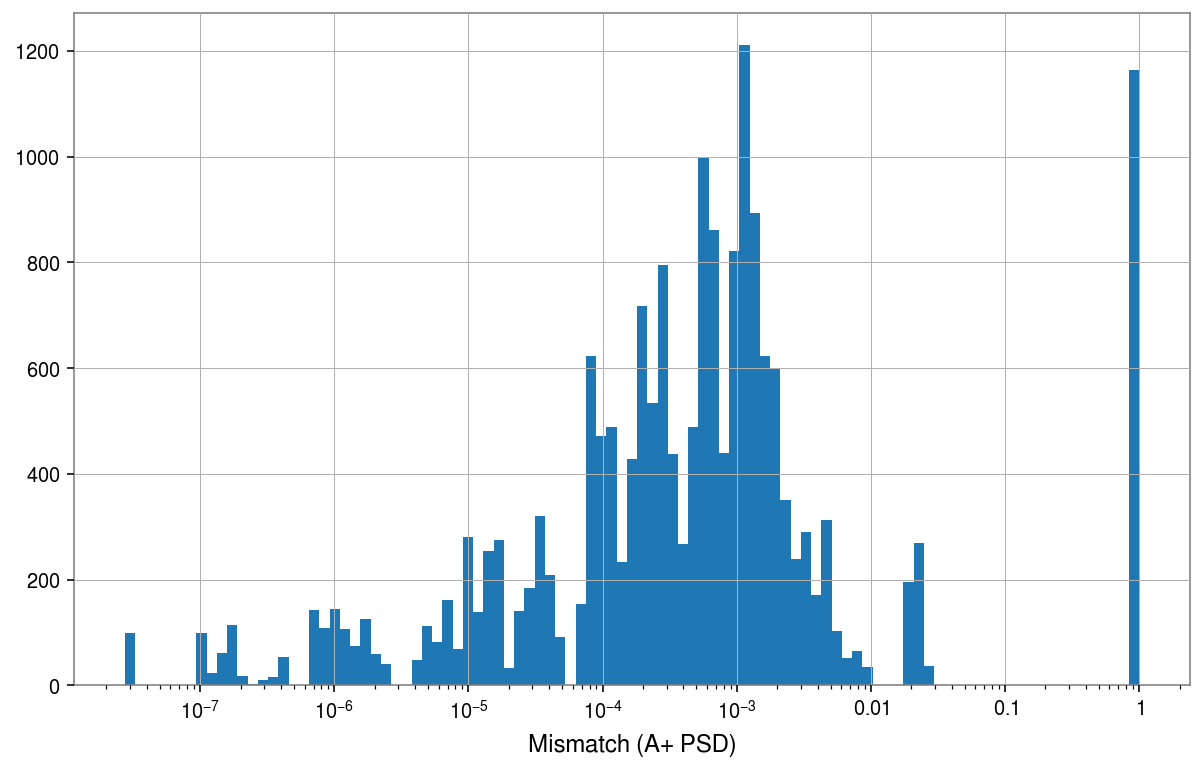

-7.547348572685765
[0.       0.002681]
0


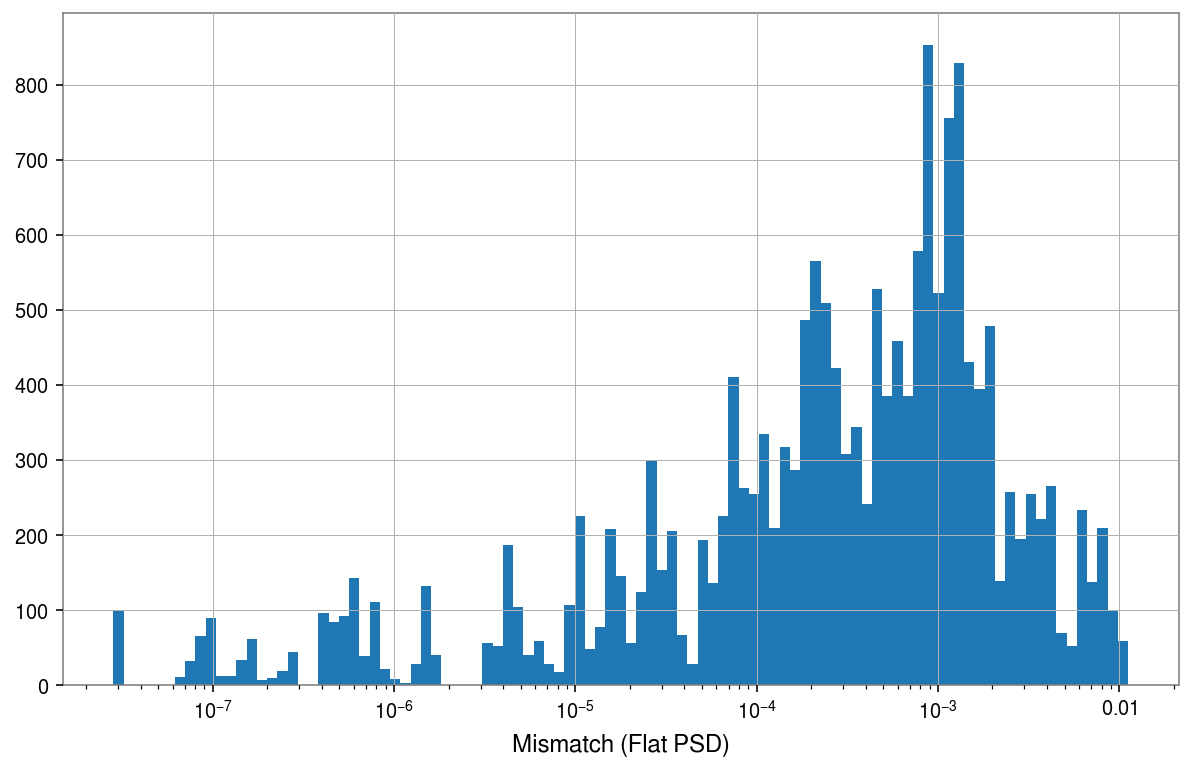

In [129]:
Aplus_hist_pick = np.less(1-Aplus_matches.flatten(), 1)

Aplus_hist_bins = np.logspace(np.log10(1-Aplus_matches.flatten()[Aplus_hist_pick ]).min(), np.log10(1-Aplus_matches.flatten()[Aplus_hist_pick ]).max(), 100)
#plus_hist_bins = np.logspace(np.log10(1-Aplus_matches.flatten()[Aplus_hist_pick ]).min(), np.log10(0.5), 100)



plt.hist(1-Aplus_matches.flatten()[Aplus_hist_pick], bins=Aplus_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()
print(np.log10(1-Flat_matches.flatten()).min())
print(np.log10(np.array([1, 1-Flat_matches.flatten().min()])))

Flat_hist_pick = np.less(1-Flat_matches.flatten(), 0.5)

#Flat_hist_bins = np.logspace(np.log10(1-Flat_matches.flatten()).min(), np.log10(np.array([0, 1-Flat_matches.flatten().min()]).max()), 100)
Flat_hist_bins = np.logspace(np.log10(1-Flat_matches.flatten()[Flat_hist_pick ]).min(), np.log10(1-Flat_matches.flatten()[Flat_hist_pick ]).max(), 100)
#Flat_hist_bins = np.logspace(np.log10(1-Flat_matches.flatten()).min(), np.log10(0.5), 100)

print(np.greater_equal(1-Flat_matches.flatten()[Flat_hist_pick], 1).sum())

plt.hist(1-Flat_matches.flatten(), bins=Flat_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (Flat PSD)')
plt.show()

In [51]:
1-Aplus_matches.flatten()

array([0.03623136, 0.03233526, 0.015362  , ..., 0.03952798,
       0.03883926, 0.03855397])

In [205]:
Nextrinsic = 30

Aplus_matches_scatter0p1 = np.zeros([N_WFs, Nextrinsic], dtype=float)
Flat_matches_scatter0p1 = np.zeros([N_WFs, Nextrinsic], dtype=float)

for i in tqdm(range(N_WFs)):
    Aplus_matches_scatter0p1[i], Flat_matches_scatter0p1[i] = NRHybSur3dq8_marg_InnerProduct(times, total_mass_samples[i], mass_ratio_samples[i], \
                                                                                             chi_1_samples[i], chi_2_samples[i], \
                                   luminosity_distance_samples[i], theta_jn_samples[i], phase_samples[i], \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., 
                                   phaseScatterSigma = 0.1, ampScatterSigma = 1/3, Nextrinsic=Nextrinsic)

100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


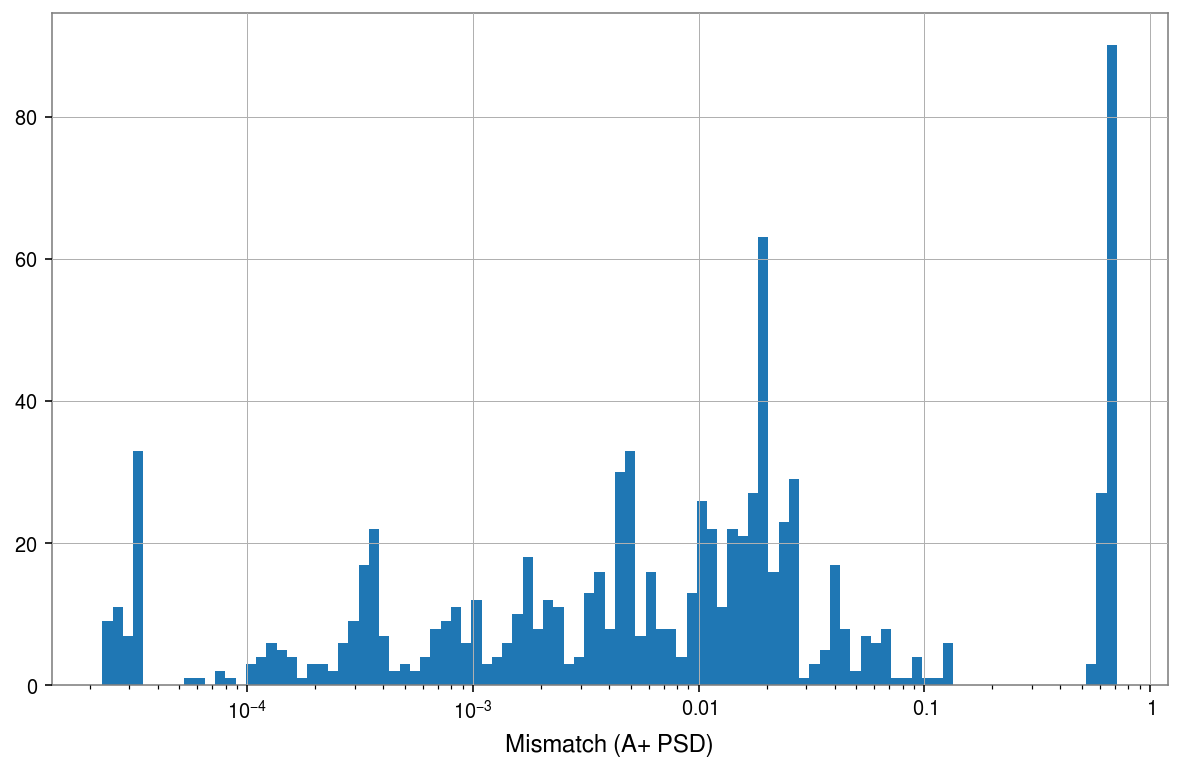

0.14222222222222222  fraction of mismatches above 0.1


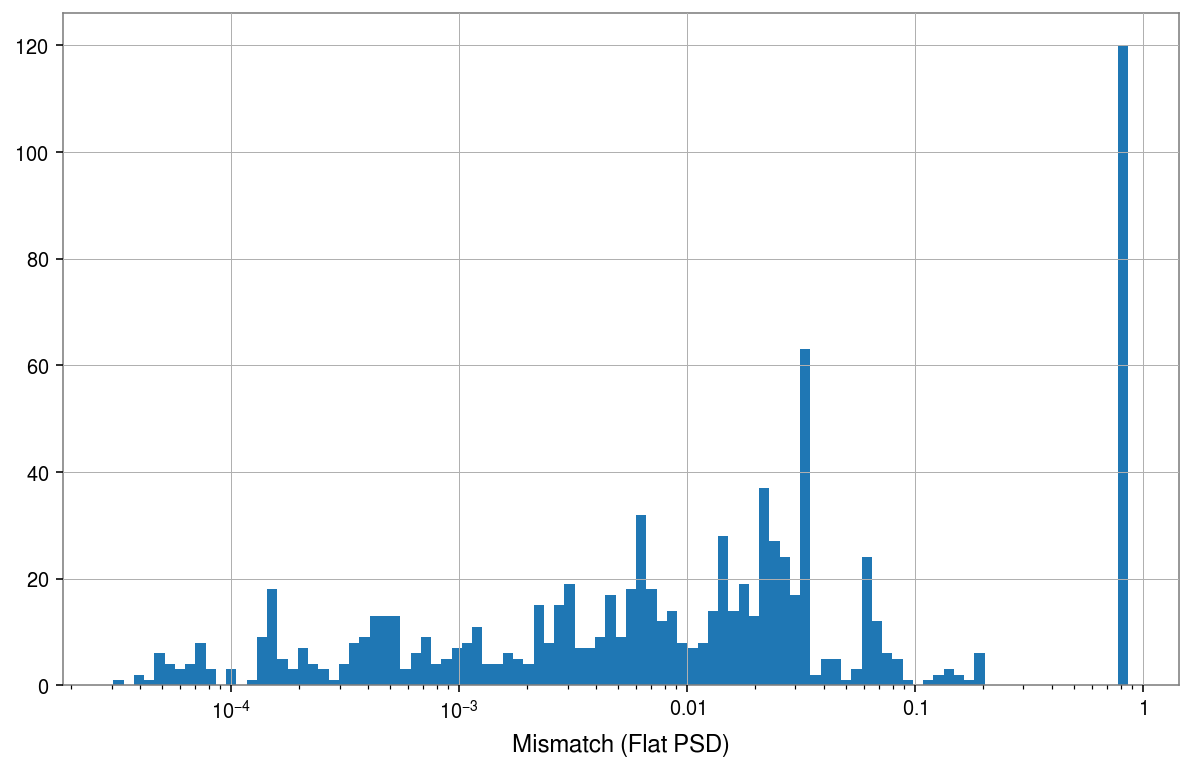

0.15  fraction of mismatches above 0.1


In [206]:
Aplus_scatter0p1_hist_bins = np.logspace(np.log10(1-Aplus_matches_scatter0p1.flatten()).min(), np.log10(1-Aplus_matches_scatter0p1.flatten()).max(), 100)

plt.hist(1-Aplus_matches_scatter0p1.flatten(), bins=Aplus_scatter0p1_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()

print(np.greater(1-Aplus_matches_scatter0p1.flatten(), 0.1).sum()/len(Aplus_matches_scatter0p1.flatten()), ' fraction of mismatches above 0.1')

#plt.hist(Flat_matches_scatter0p1.flatten())
#print(Flat_matches_scatter0p1.flatten().shape)


#Flat_notNaN = np.logical_not(np.isnan(Flat_matches_scatter0p1.flatten()))
Flat_notNaN = np.less_equal(Flat_matches_scatter0p1.flatten(), 1.)
#print(Flat_matches_scatter0p1.flatten()[Flat_notNaN].shape)

#print((1-Flat_matches_scatter0p1.flatten()[Flat_notNaN]).min(), (1-Flat_matches_scatter0p1.flatten()[Flat_notNaN]).max())
#print(np.log10((1-Flat_matches_scatter0p1.flatten()[Flat_notNaN]).min()), np.log10((1-Flat_matches_scatter0p1.flatten()[Flat_notNaN]).max()))

Flat_scatter0p1_hist_bins = np.logspace(np.log10(1-Flat_matches_scatter0p1.flatten()[Flat_notNaN]).min(), \
                                        np.log10(1-Flat_matches_scatter0p1.flatten()[Flat_notNaN]).max(), 100)

#print(Flat_scatter0p1_hist_bins)

plt.hist(1-Flat_matches_scatter0p1.flatten()[Flat_notNaN], bins=Flat_scatter0p1_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (Flat PSD)')
plt.show()

print(np.greater(1-Flat_matches_scatter0p1.flatten()[Flat_notNaN], 0.1).sum()/len(Flat_matches_scatter0p1.flatten()[Flat_notNaN]), ' fraction of mismatches above 0.1')



In [207]:
Nextrinsic = 10

Aplus_matches_scatter1eminus4 = np.zeros([N_WFs, Nextrinsic], dtype=float)
Flat_matches_scatter1eminus4 = np.zeros([N_WFs, Nextrinsic], dtype=float)

for i in tqdm(range(N_WFs)):
    Aplus_matches_scatter1eminus4[i], Flat_matches_scatter1eminus4[i] = NRHybSur3dq8_marg_InnerProduct(times, total_mass_samples[i], mass_ratio_samples[i], \
                                                                                             chi_1_samples[i], chi_2_samples[i], \
                                   luminosity_distance_samples[i], theta_jn_samples[i], phase_samples[i], \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., 
                                   phaseScatterSigma = 1e-4, ampScatterSigma = 1/3, Nextrinsic=Nextrinsic)

100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


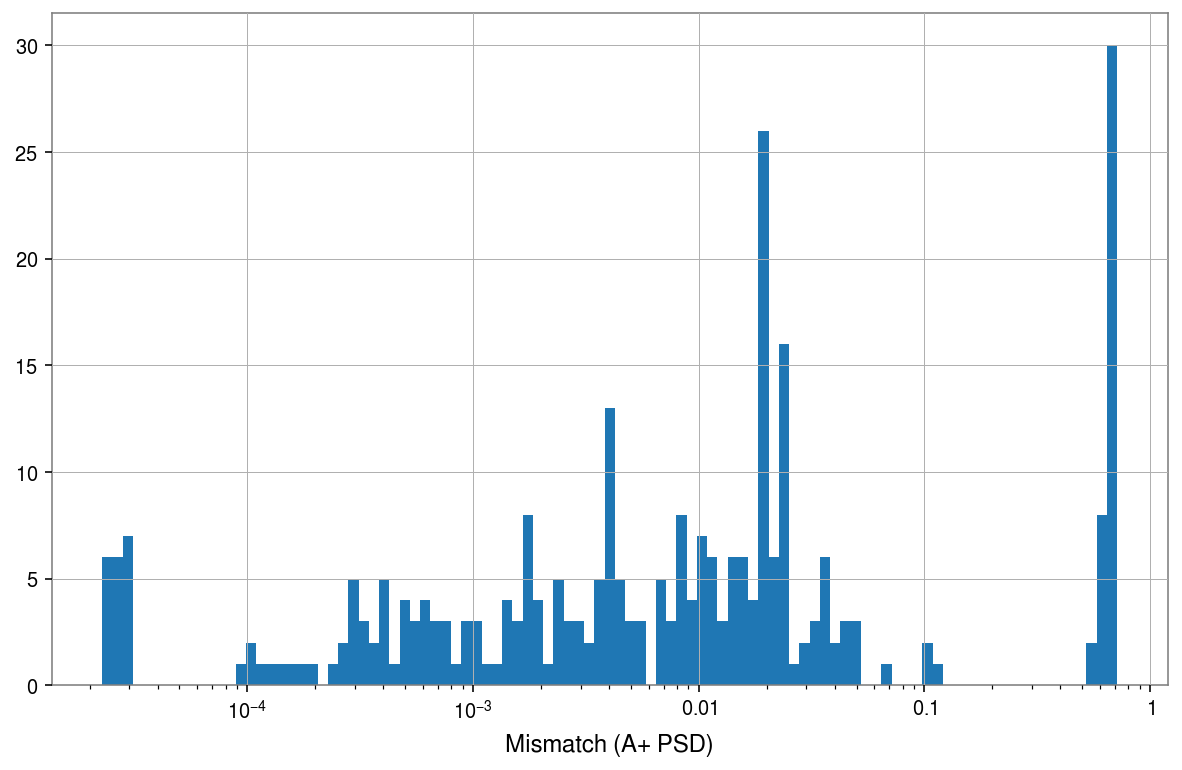

0.14333333333333334  fraction of mismatches above 0.1


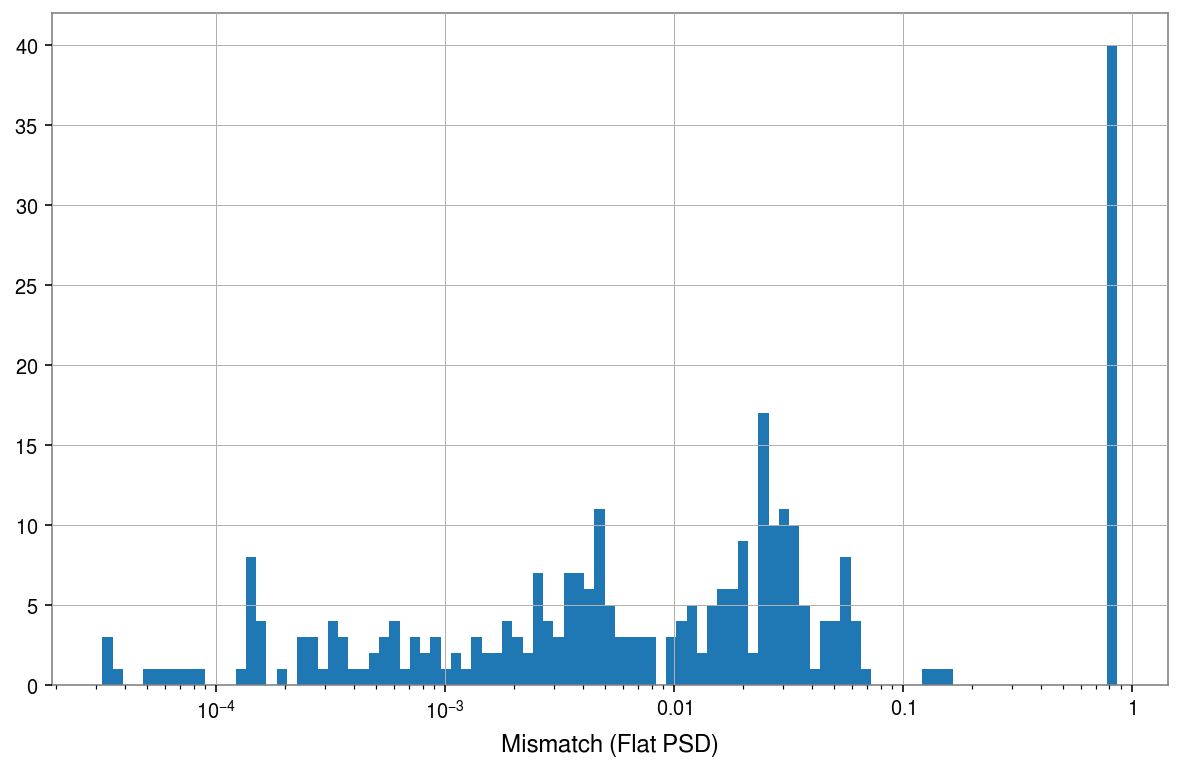

0.14333333333333334  fraction of mismatches above 0.1


In [208]:
Aplus_pick= np.less_equal(Aplus_matches_scatter1eminus4.flatten(), 1.)

Aplus_scatter1eminus4_hist_bins = np.logspace(np.log10(1-Aplus_matches_scatter1eminus4.flatten()[Aplus_pick]).min(),\
                                              np.log10(1-Aplus_matches_scatter1eminus4.flatten()[Aplus_pick]).max(), 100)

plt.hist(1-Aplus_matches_scatter1eminus4.flatten()[Aplus_pick], bins=Aplus_scatter1eminus4_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()

print(np.greater(1-Aplus_matches_scatter1eminus4.flatten(), 0.1).sum()/len(Aplus_matches_scatter1eminus4.flatten()), ' fraction of mismatches above 0.1')

Flat_notNaN = np.less_equal(Flat_matches_scatter1eminus4.flatten(), 1.)

Flat_scatter1eminus4_hist_bins = np.logspace(np.log10(1-Flat_matches_scatter1eminus4.flatten()[Flat_notNaN]).min(), \
                                        np.log10(1-Flat_matches_scatter1eminus4.flatten()[Flat_notNaN]).max(), 100)

plt.hist(1-Flat_matches_scatter1eminus4.flatten()[Flat_notNaN], bins=Flat_scatter1eminus4_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (Flat PSD)')
plt.show()

print(np.greater(1-Flat_matches_scatter1eminus4.flatten()[Flat_notNaN], 0.1).sum()/len(Flat_matches_scatter1eminus4.flatten()[Flat_notNaN]), ' fraction of mismatches above 0.1')



In [209]:
bigPeakIndex = np.ones_like(Aplus_matches_scatter1eminus4)

for i in range(N_WFs):
    bigPeakIndex[i,:] = i
    
bigPeakIndex = bigPeakIndex.flatten()
    
bigPeakPick = np.logical_and(np.greater_equal(1-Aplus_matches_scatter1eminus4.flatten(), 0.), np.greater(1-Aplus_matches_scatter1eminus4.flatten(), 0.1))

In [210]:
Aplus_matches_scatter1eminus4.min()

0.2866143715185151

43


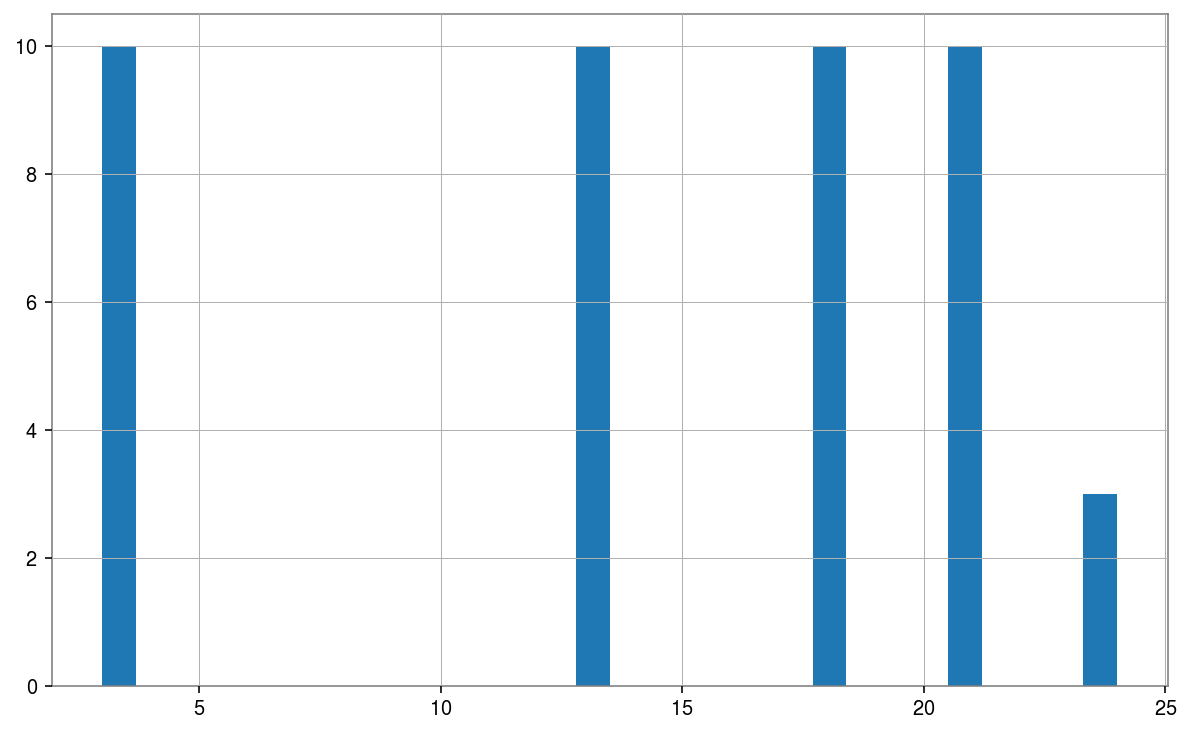

[ 3 13 18 21]


In [211]:
bigPeakIndex[bigPeakPick]
print(bigPeakPick.sum())

plt.hist(bigPeakIndex[bigPeakPick], bins=N_WFs)
plt.show()

print(np.arange(N_WFs)[bigPeakPick.reshape([N_WFs, Nextrinsic])[:,0]])

bigPeakPickPick = bigPeakPick.reshape([N_WFs, Nextrinsic])[:,0]

In [212]:
print(total_mass_samples[bigPeakPickPick])
print(1/mass_ratio_samples[bigPeakPickPick])
print(chi_1_samples[bigPeakPickPick])
print(chi_2_samples[bigPeakPickPick])
print(theta_jn_samples[bigPeakPickPick])

[59.62245564 69.91196706 66.05329313 67.92364484]
[1.44072689 1.09020576 1.12586264 2.252323  ]
[-0.04854663 -0.35687995 -0.1957662  -0.62602663]
[0.64834242 0.48919748 0.34408936 0.11901664]
[1.15684361 0.93117433 1.98127107 1.87175565]


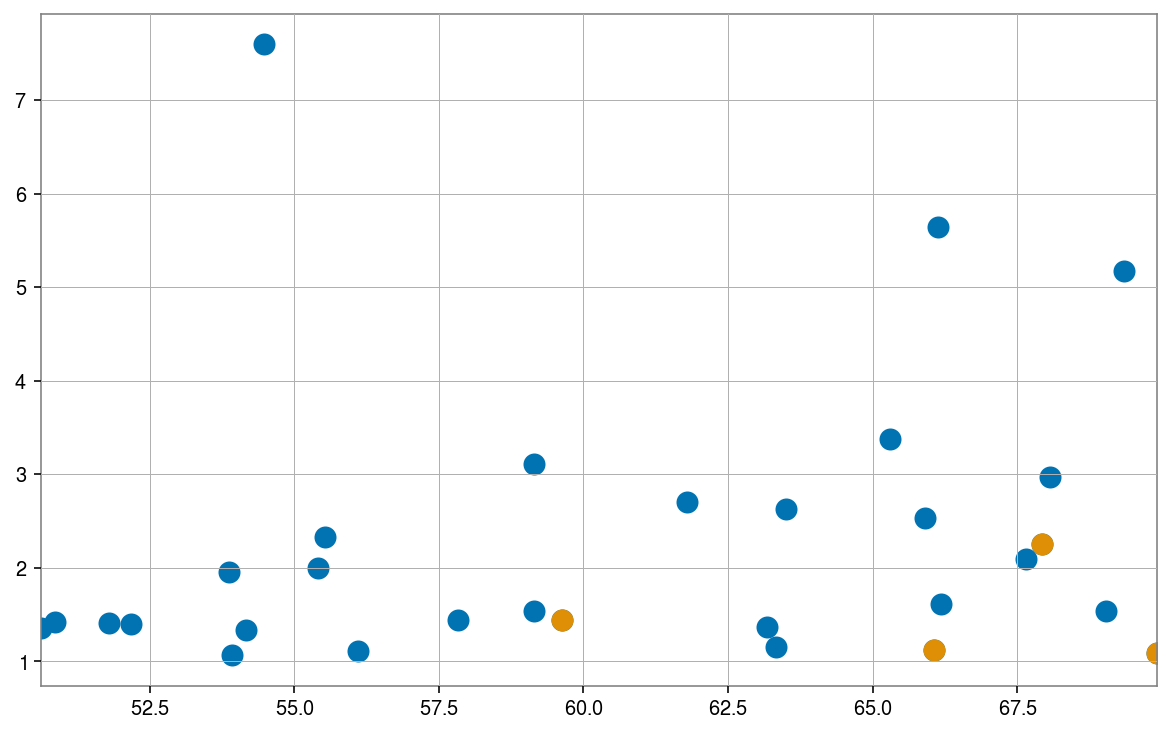

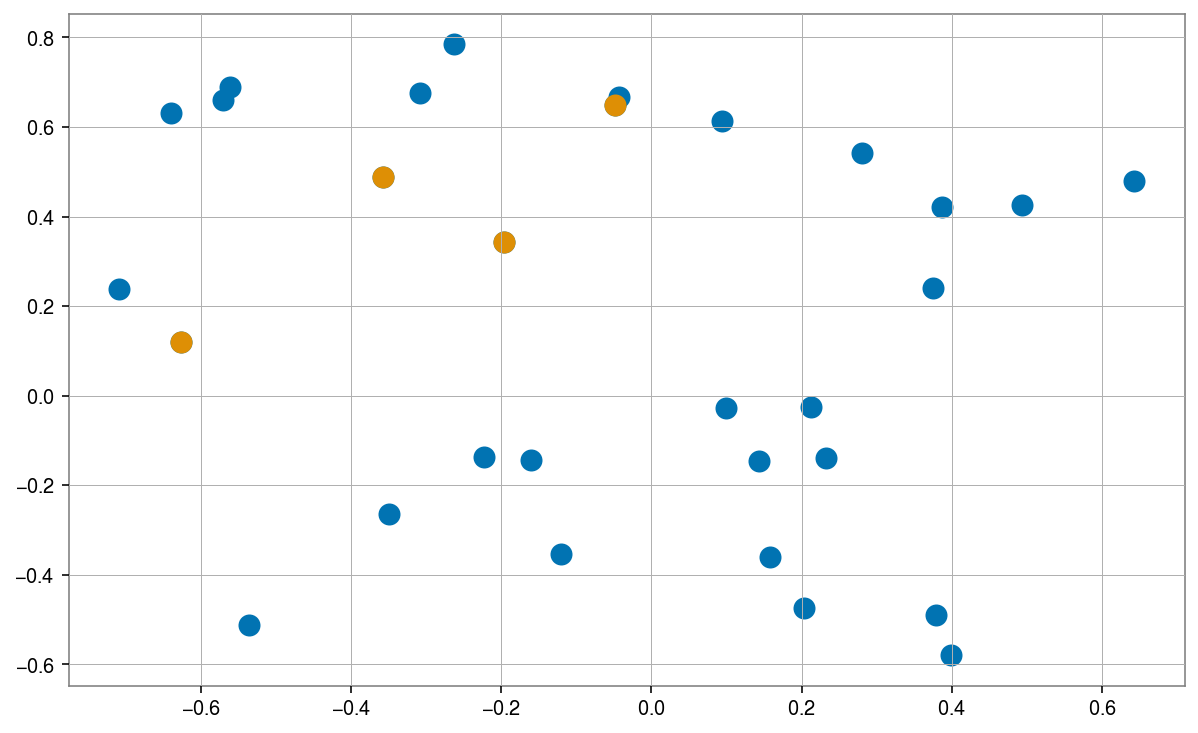

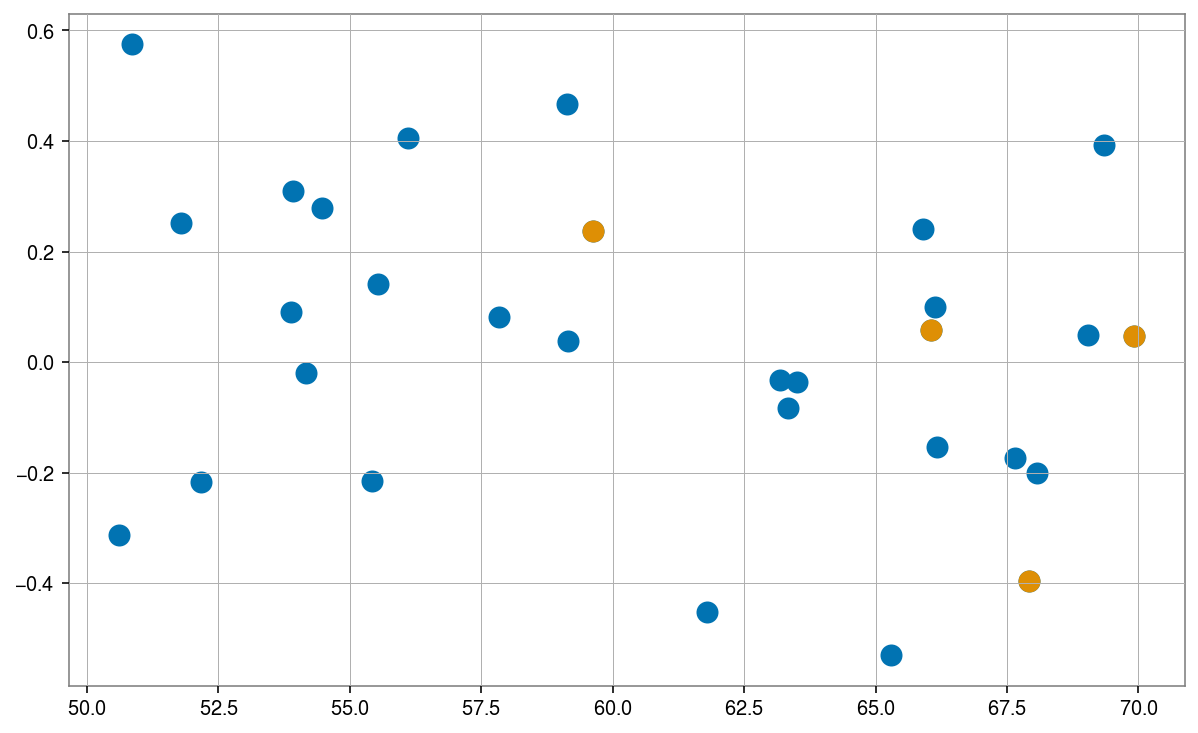

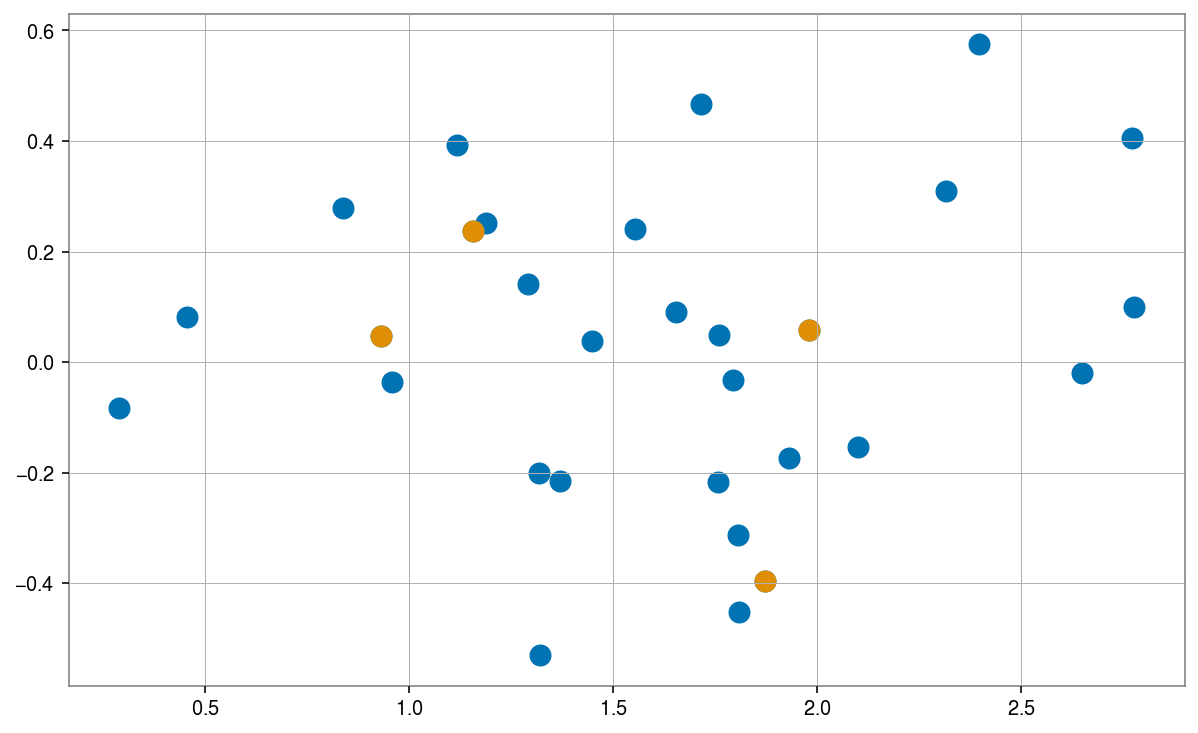

In [213]:
plt.scatter(total_mass_samples, 1/mass_ratio_samples, color=cp[0], s=100)
plt.scatter(total_mass_samples[bigPeakPickPick], 1/mass_ratio_samples[bigPeakPickPick], color=cp[1], s=100)
plt.xlim(total_mass_samples.min(), total_mass_samples.max())
plt.show()
plt.scatter(chi_1_samples, chi_2_samples, color=cp[0], s=100)
plt.scatter(chi_1_samples[bigPeakPickPick], chi_2_samples[bigPeakPickPick], color=cp[1], s=100)
#plt.xlim(total_mass_samples.min(), total_mass_samples.max())
plt.show()

def chi_eff(chi1, chi2, q):
    return (chi1 + (q*chi2))/(1+q)
plt.scatter(total_mass_samples, chi_eff(chi_1_samples, chi_2_samples, mass_ratio_samples), color=cp[0], s=100)
plt.scatter(total_mass_samples[bigPeakPickPick], chi_eff(chi_1_samples, chi_2_samples, mass_ratio_samples)[bigPeakPickPick], color=cp[1], s=100)
plt.show()
plt.scatter(theta_jn_samples, chi_eff(chi_1_samples, chi_2_samples, mass_ratio_samples), color=cp[0], s=100)
plt.scatter(theta_jn_samples[bigPeakPickPick], chi_eff(chi_1_samples, chi_2_samples, mass_ratio_samples)[bigPeakPickPick], color=cp[1], s=100)

In [196]:
plt.hist(1-Aplus_matches_scatter1eminus4[bigPeakPick].flatten(), bins=Aplus_scatter1eminus4_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 500

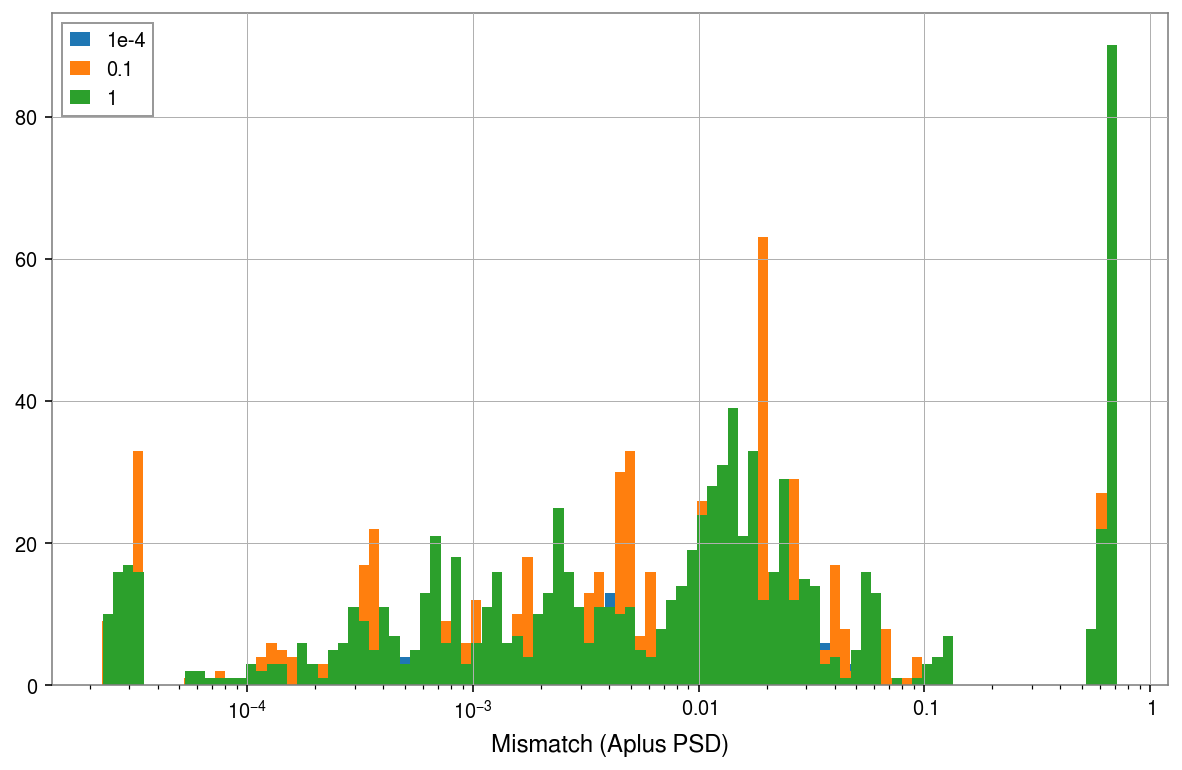

In [214]:
plt.hist(1-Aplus_matches_scatter1eminus4.flatten(), bins=Aplus_scatter1eminus4_hist_bins, label='1e-4' )
plt.hist(1-Aplus_matches_scatter0p1.flatten(), bins=Aplus_scatter0p1_hist_bins , label='0.1')
plt.hist(1-Aplus_matches.flatten(), bins=Aplus_hist_bins, label='1' )
plt.xscale('log')
plt.legend()
plt.xlabel('Mismatch (Aplus PSD)')
plt.show()

/home/carl-johan.haster/.conda/envs/WF_marg_igwn-py37/lib/python3.7/site-packages/numpy/lib/histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


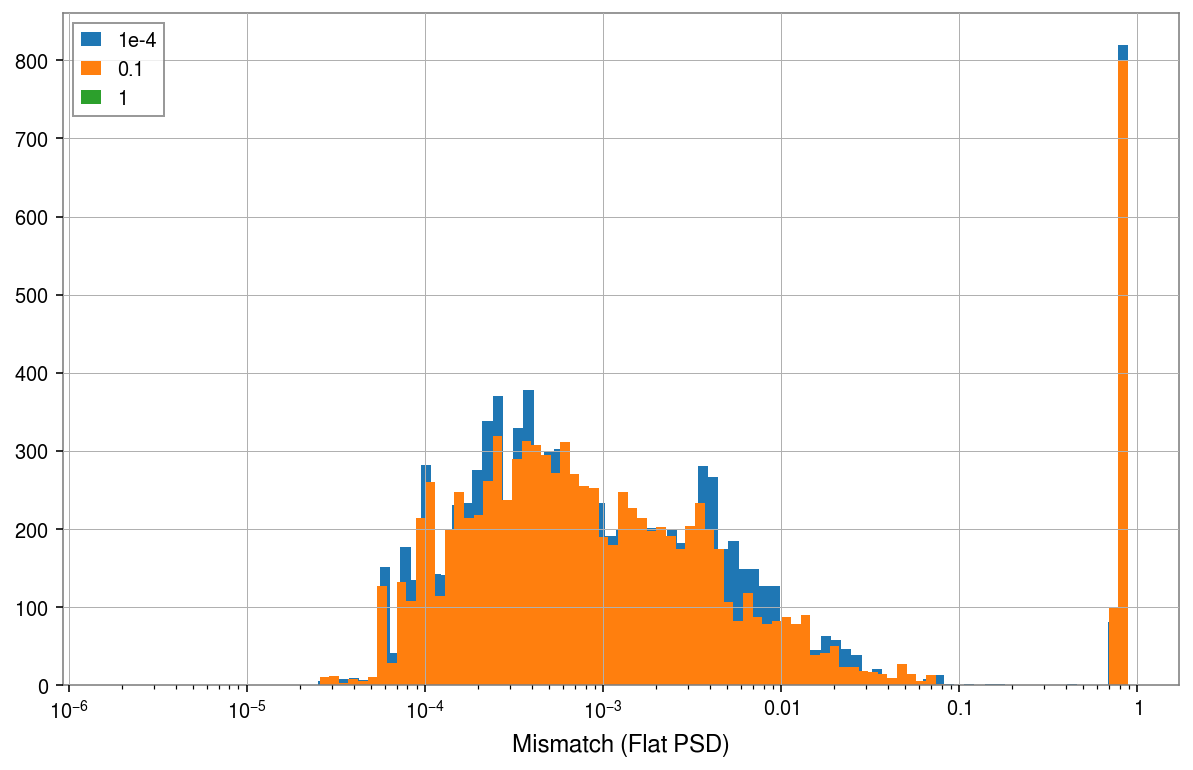

In [113]:
plt.hist(1-Flat_matches_scatter1eminus4.flatten(), bins=Flat_scatter1eminus4_hist_bins, label='1e-4' )
plt.hist(1-Flat_matches_scatter0p1.flatten(), bins=Flat_scatter0p1_hist_bins , label='0.1')
plt.hist(1-Flat_matches.flatten(), bins=Flat_hist_bins, label='1' )
plt.xscale('log')
plt.legend()
plt.xlabel('Mismatch (Flat PSD)')
plt.show()

In [ ]:
Nextrinsic = 100

Aplus_matches_scatter1eminus4_1over10 = np.zeros([N_WFs, Nextrinsic], dtype=float)
Flat_matches_scatter1eminus4_1over10 = np.zeros([N_WFs, Nextrinsic], dtype=float)

for i in tqdm(range(N_WFs)):
    Aplus_matches_scatter1eminus4_1over10[i], Flat_matches_scatter1eminus4_1over10[i] = NRHybSur3dq8_marg_InnerProduct(times, total_mass_samples[i], mass_ratio_samples[i], \
                                                                                             chi_1_samples[i], chi_2_samples[i], \
                                   luminosity_distance_samples[i], theta_jn_samples[i], phase_samples[i], \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., 
                                   phaseScatterSigma = 1e-8, ampScatterSigma = 1/100, Nextrinsic=Nextrinsic,  TimePhaseMax=True, printInnerProds=False)

 44%|████▍     | 22/50 [01:25<01:48,  3.88s/it]

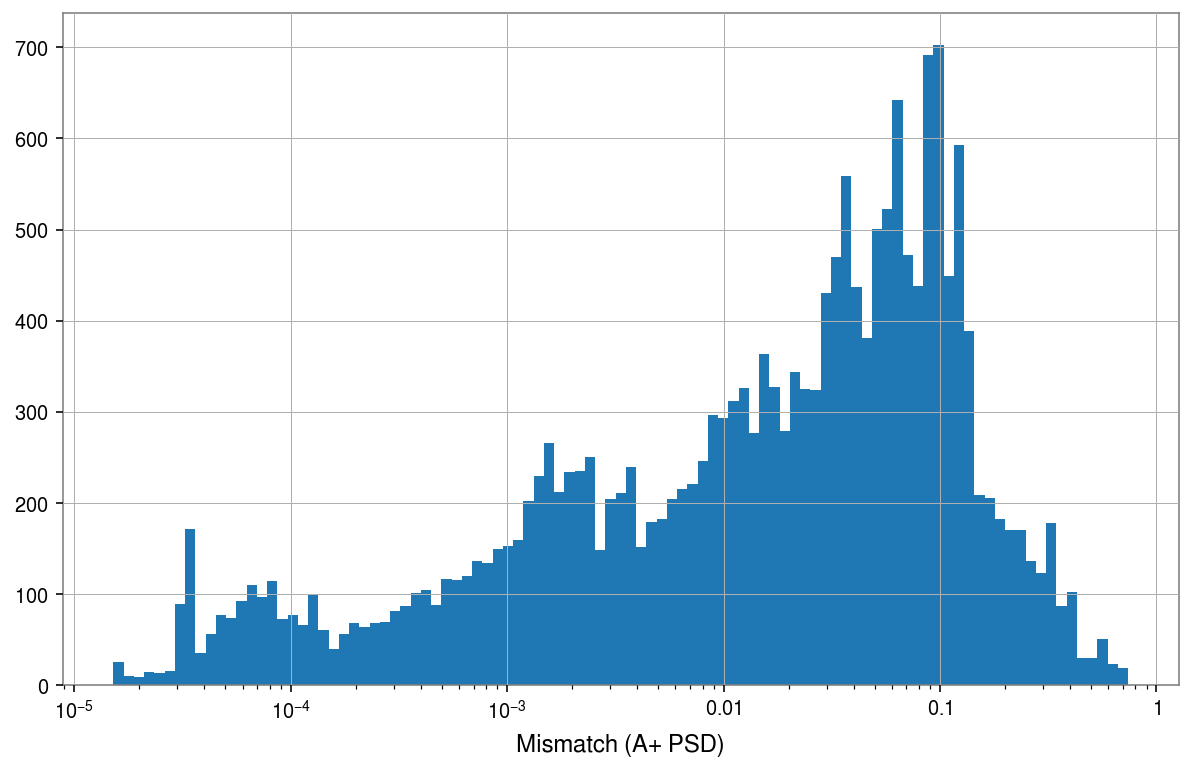

0.2739184740248073 1.0000365640852593


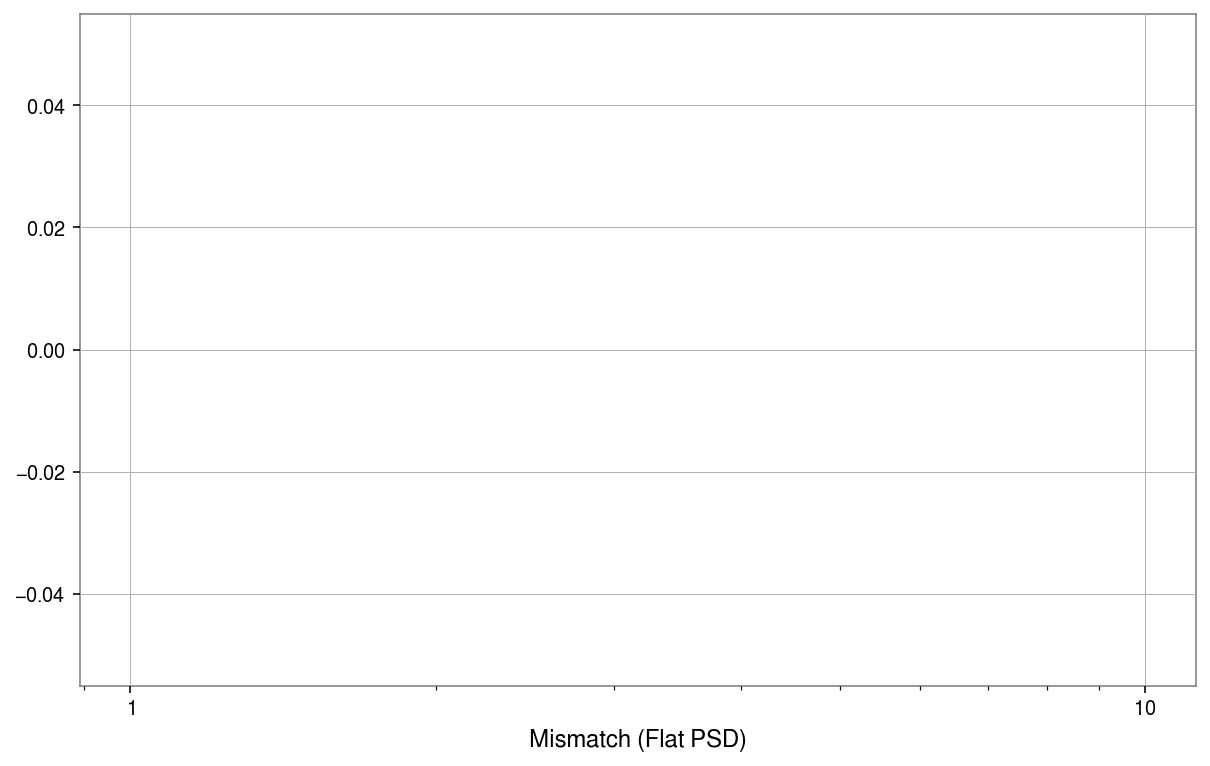

In [131]:
Aplus_scatter1eminus4_1over10_hist_bins = np.logspace(np.log10(1-Aplus_matches_scatter1eminus4_1over10.flatten()).min(), \
                                                      np.log10(1-Aplus_matches_scatter1eminus4_1over10.flatten()).max(), 100)

plt.hist(1-Aplus_matches_scatter1eminus4_1over10.flatten(), bins=Aplus_scatter1eminus4_1over10_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()

print(Flat_matches_scatter1eminus4_1over10.flatten().min(), Flat_matches_scatter1eminus4_1over10.flatten().max())

#Flat_scatter1eminus4_1over10_hist_bins = np.logspace(np.log10(1-Flat_matches_scatter1eminus4_1over10.flatten()).min(), \
#                                                     np.log10(1-Flat_matches_scatter1eminus4_1over10.flatten()).max(), 100)
plt.hist(1-Flat_matches_scatter1eminus4_1over10.flatten(), bins=Flat_scatter1eminus4_1over10_hist_bins )
plt.xscale('log')
plt.xlabel('Mismatch (Flat PSD)')
plt.show()

In [16]:
Aplus_matches_scatter1eminus4_1over10_b = np.zeros([N_WFs, Nextrinsic], dtype=float)
Flat_matches_scatter1eminus4_1over10_b = np.zeros([N_WFs, Nextrinsic], dtype=float)

for i in tqdm(range(N_WFs)):
    Aplus_matches_scatter1eminus4_1over10_b[i], Flat_matches_scatter1eminus4_1over10_b[i] = NRHybSur3dq8_marg_InnerProduct(times, total_mass_samples[i], mass_ratio_samples[i], \
                                                                                             chi_1_samples[i], chi_2_samples[i], \
                                   luminosity_distance_samples[i], theta_jn_samples[i], phase_samples[i], \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., 
                                   phaseScatterSigma = 1e-8, ampScatterSigma = 1/100, Nextrinsic=Nextrinsic,  \
                                     TimePhaseMax=True, printInnerProds=False, NumPointStep=10)

100%|██████████| 100/100 [06:17<00:00,  3.77s/it]


In [137]:
Aplus_matches_scatter1eminus4_1over10_c = np.zeros([N_WFs, Nextrinsic], dtype=float)
Flat_matches_scatter1eminus4_1over10_c = np.zeros([N_WFs, Nextrinsic], dtype=float)

for i in tqdm(range(N_WFs)):
    Aplus_matches_scatter1eminus4_1over10_c[i], Flat_matches_scatter1eminus4_1over10_c[i] = NRHybSur3dq8_marg_InnerProduct(times, total_mass_samples[i], mass_ratio_samples[i], \
                                                                                             chi_1_samples[i], chi_2_samples[i], \
                                   luminosity_distance_samples[i], theta_jn_samples[i], phase_samples[i], \
                                   reference_frequency=20, sampling_frequency=4096., minimum_frequency=20., 
                                   phaseScatterSigma = 1e-8, ampScatterSigma = 1/100, Nextrinsic=Nextrinsic,  \
                                     TimePhaseMax=True, printInnerProds=True, NumPointStep=100)

  0%|          | 0/50 [00:00<?, ?it/s]

284.68954130586326 284.1926847620135 284.2568006035788 	 362.4216358306564 361.36842453709085 361.66136541820407
296.2156574482128 295.6883961071167 295.80498960793767 	 377.2967462597272 376.5668837253813 377.3864062939844
143.9006884415239 143.8380066124761 143.8767373831948 	 183.38556263994187 183.19291361805548 183.24077083950147
93.42824632045377 93.38079141244911 93.44460581817877 	 119.22149779689589 119.381666900678 119.81061216338088
159.59183049555813 159.36642068191932 159.46242575588641 	 203.46819284068835 203.4192164445528 204.14622182779803
93.743761459949 93.64060494255688 93.7036245792415 	 119.57056563026389 119.63760273447294 120.1063211276978
146.1556454035143 146.07764180448285 146.17798913966035 	 186.50448930979593 186.75317512624915 187.43275586265494


  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

100.6621824651619 100.48739707824436 100.50944302777958 	 128.14530092002104 127.76949835339748 127.86596775059307
47.495966422940164 47.479557662538035 47.494432975161224 	 60.541019924434615 60.500084983688 60.53333606622042
240.388145818602 240.313709973427 240.46549113367163 	 306.74327046145436 307.1344577397945 308.070543860121
97.7339938116818 97.5782356024297 97.78243392707536 	 132.8780036567874 132.7391044591008 132.88557298606725
20.185088522649338 20.155176159629036 20.200997561697466 	 27.4159662034548 27.402910441157214 27.45312458076053
12.873435194248284 12.789745093560247 12.854540498453888 	 17.251709497197336 17.217634632257994 17.459631496274532
101.23121532772286 101.08549066057665 101.37020934701648 	 137.0937358668108 137.20251103798498 137.76010714041507
1.6693901457686933 1.5006107607159374 1.4847416366615973 	 2.476808624149887 2.0747159560946726 1.9977291230443408
11.058498114715368 11.023981598214684 11.068747700533857 	 14.884030189509021 14.898815264628665

  4%|▍         | 2/50 [00:02<01:00,  1.26s/it]

42.78971628500761 42.70609974343662 42.78018222244652 	 58.29400910853594 58.155323225617394 58.13666596188874
18.934766460084738 18.90783977249409 18.95996072995425 	 25.650786405491008 25.668395361743126 25.76630204962593
49.53826709700916 49.358834806452464 49.56881178440029 	 66.61643514115683 66.66007147544401 67.34636917129207
34.794942538136475 34.740343670121284 34.814217992432255 	 47.29790054742844 47.25374955072895 47.31230963232531
45.21995386546035 45.22341878494994 45.24350879901757 	 69.80824382159567 69.87946165501948 69.98815333190542
79.0822844919856 79.07909273113052 79.09862775841498 	 122.37195969678396 122.4691591393646 122.62151328156098
96.09173344690609 96.09253981877156 96.12512147041818 	 148.5612763535636 148.69784667301448 148.9081602997633
95.91213087632214 95.9740289019073 96.08115560997814 	 145.9227462318116 146.10112736557122 146.37750982004323
30.013494904795635 30.02493728668521 30.050089023499783 	 45.99039842598864 46.047141441500806 46.13342543063

  6%|▌         | 3/50 [00:03<00:58,  1.24s/it]

4.419087674750499 4.422158576235823 4.426738477968198 	 6.704879985357352 6.710211676156491 6.719175149882687
24.919647338692826 24.938246974886237 24.966508878422726 	 37.77376670639833 37.80895425042021 37.86648616279056
61.59567081920367 61.623577211531384 61.68025890296279 	 94.20817840011976 94.32602615899019 94.50574037282817
41.31313234599472 41.246808991712264 41.26591628532268 	 53.39523307291745 53.398608119043935 53.621634882487214
20.47435750546757 20.459224705232607 20.461517071212032 	 26.538451891186515 26.548749587947636 26.588192951740595
49.71400221602472 49.588533013425454 49.64725369213114 	 63.98703045980959 64.02447498695267 64.6025859321346
212.5834248508573 212.03426464636533 212.33904256291987 	 273.3669920761648 273.6781457594147 276.5568134106238
99.80356073072326 99.6274306849169 99.68288608086053 	 128.91131403901022 128.9210118647262 129.54451109551178
41.13756791505339 41.06730031105426 41.11947271084338 	 53.02351748930317 53.127741026372135 53.596239440

  8%|▊         | 4/50 [00:04<00:56,  1.22s/it]

315.8515650516835 315.3057974671312 315.7092521045052 	 407.08281415610566 407.88092326856975 411.5057931904262
177.84408615908353 177.77095810893735 177.8025571720349 	 230.62650075789108 230.86117477575144 231.22672233402156
475.0819128584058 473.8510272553456 474.46759631275404 	 611.1711239727316 611.6505165589672 617.6149873746175
214.3446438925663 214.21370516758589 214.234286568722 	 277.91642821546776 278.0630086931193 278.42192396440305
140.00896167840818 139.92854079647233 139.87317818278547 	 170.7215433671086 170.53201151843697 170.38637726713796
965.8993598679315 965.5073609304213 965.3435957293615 	 1175.4056405799192 1175.3876438655343 1175.9613901117173
496.4715140601256 496.2727798555488 496.19737956160856 	 603.9992426859568 604.0630791325792 604.4542336788927
246.87144406882183 246.7707482756579 246.74873546066664 	 299.9490243873284 300.14732545532445 300.56980448210356
535.0298123228225 534.7898484512891 534.7289965996538 	 650.0070674391108 650.4262317547374 651.3

 10%|█         | 5/50 [00:06<00:54,  1.22s/it]

1084.0255102346719 1083.4043841396058 1083.0561345993378 	 1319.9745118675396 1319.3117357829879 1319.2695678154018
369.46006949556505 369.28701547903194 369.1779517137072 	 450.29327114016553 449.9472892455904 449.7314833489162
696.6459666901396 696.3288998341501 696.1382685250256 	 848.8672457976897 848.3147395620585 848.0333822584087
390.7908429570689 390.61695697134763 390.51699628303123 	 476.0846477876157 475.8228720691365 475.7261014453258
156.2384885284485 156.23736273574184 156.30420270147292 	 191.42543494701218 191.4476463433915 191.63964349060197
269.65246821105904 269.68911231231607 269.81495464936467 	 331.0087690706316 331.2205109409048 331.6808048446935
126.23268805660979 126.24375076938215 126.29571827378132 	 154.8060296196566 154.85618190327563 155.0192749448418
342.4965581884898 342.51425776191064 342.6540857487538 	 419.8428234012414 419.9324269494497 420.34696156705616
91.94383918362574 91.93244110208566 91.99155280256333 	 112.69288028188517 112.75035420755155 11

 12%|█▏        | 6/50 [00:07<00:53,  1.21s/it]

274.5450191173103 274.5795064643679 274.7006495841275 	 336.909401235855 337.0869257225013 337.50848866108424
118.53653101663151 118.55248057303449 118.61500788160849 	 145.5747591320963 145.6967223297901 145.94246779402678
497.9213587458557 497.9018823120645 498.25004930679546 	 611.1323809104042 611.7009151063661 613.1048058669331
46.08838944665056 46.15268461037092 46.22568688589241 	 76.38515301882026 76.61958770249277 76.91524233674052
22.34074117524217 22.37891748301093 22.42454185237712 	 38.20134395538998 38.33562194150024 38.50953468745269
29.221345759213833 29.247987083354747 29.287110237730996 	 50.28397456015303 50.419987067735875 50.61258510313081
27.126330377689076 27.1686339004801 27.21653748583759 	 45.21016364586041 45.357881825597616 45.54352788584073
1.9310975128036956 1.9344833315913454 1.9384858192956809 	 3.2955234463272456 3.3072395554308422 3.3223161420518634
1.3689598588381389 1.3682802369411093 1.368204615587819 	 2.3157858919896213 2.318423686624632 2.3235204

 14%|█▍        | 7/50 [00:08<00:52,  1.23s/it]

5.585902829832459 5.5888626333685245 5.594303668674106 	 9.591696421701041 9.613728013135072 9.646571494765587
51.11983237326859 51.21155356735984 51.318503942475644 	 86.94299463827441 87.25486824549351 87.65288175591212
12.329482740805549 12.35128966954215 12.376956196048473 	 21.02091450019125 21.095921090888964 21.192188727035056
58.21827437779749 58.19739433876301 58.185694681339044 	 80.55152224311195 80.48420938813622 80.44920757957419
47.94929859553095 47.93034380808579 47.923400140020654 	 66.6800953633501 66.79277357171803 66.9472992752465
42.367314321898945 42.35131572542677 42.345207211259726 	 58.92877876993605 59.02352743600901 59.152565764063446
41.67569221365439 41.64165445670036 41.63346405991241 	 57.49521285034658 57.62073226587702 57.8406234132938
51.09148561647348 51.06159351178215 51.04972487588526 	 70.36532203615049 70.315325321373 70.33085542820638
55.3715960744165 55.356771461702074 55.34680943366522 	 76.8171023724154 76.77631334185719 76.7515609744785
53.834

 16%|█▌        | 8/50 [00:09<00:50,  1.21s/it]

55.897211515353874 55.85423414380833 55.84058565667414 	 76.79547891686583 76.79228205458061 76.8964036408425
139.35101776982543 139.2341476960589 139.20022604744972 	 191.3671346078561 191.44888883866733 191.83460226967335
32.377236402490865 32.3483661316522 32.34076756895222 	 44.48245737684911 44.531959404689566 44.659467963818976
48.38116735098482 48.37866582177415 48.379361335650685 	 66.95864659612403 66.9868595205426 67.02810077305053
44.15267159595646 44.15135129553207 44.15343437671061 	 60.79913820561018 60.83591952877112 60.886631823640094
0.92162824783688 0.9218743448728585 0.9222998736827307 	 1.2332785794842074 1.2351644930775842 1.2377625338144687
7.943554413352907 7.943120024475613 7.943193889270118 	 11.009358300543367 11.013403387648557 11.01951225173973
122.35847278504008 122.35177172668776 122.35284093616025 	 169.67723921723393 169.73585230644463 169.8259480181518
6.981031972239607 6.981382422040712 6.9825210829378435 	 9.49042629282197 9.500459919470465 9.51371168

 18%|█▊        | 9/50 [00:10<00:48,  1.19s/it]

3.7091434810507624 3.7101179187337463 3.7118070058776063 	 4.967338113950572 4.974790684723332 4.985078384965527
89.97605183246522 89.974536882677 89.98050474791678 	 123.6029987610795 123.68831635117115 123.80427170543679
48.781779704009345 48.77943690995677 48.780417596459316 	 67.43963357853825 67.47076966776937 67.51547257548768
148.96763855784408 148.09816793828028 147.71616872014047 	 194.29789693287287 194.07981776592646 195.3357032985816
19.077380788797072 18.822953881557424 18.801674749581117 	 25.60425731716802 24.665600695930635 24.67327852148788
109.92387245354321 109.29113862519513 109.00719695608153 	 143.36660080969867 143.23499129235083 144.14282900919198
58.25572793786972 57.88406745755972 57.74192948854033 	 76.01970481548206 75.82025695979797 76.36909422592491
9.866768380759188 9.735101815960713 9.724420299793342 	 13.20801811242956 12.746948040992859 12.776727421035389
42.0251217742914 41.741365155759325 41.642335280821925 	 54.86614113584362 54.66013747957086 55.07

 20%|██        | 10/50 [00:11<00:46,  1.16s/it]

27.002160024790076 26.76504837066352 26.71319290029112 	 35.39804643708085 35.01024910351968 35.31845205338736
33.631212178307514 33.48992908096015 33.38844015137932 	 44.083980574735556 44.030372506170934 44.00336034005021
28.06833898411352 27.75651639459388 27.715710456455557 	 37.069749867706115 36.29048405421736 36.58220371272651
14.605367282235523 14.631216586984984 14.665885597571583 	 21.240750491221227 21.28184760128477 21.331852021778673
112.80137854073034 112.86264595881515 112.95832598400618 	 165.7902747836612 166.03470799121453 166.30732017218114
43.01764891366538 42.97628086527934 42.96013851894878 	 63.503328506490575 63.51685038990489 63.56073450041153
30.69502293089254 30.740569082411216 30.798587482301212 	 44.826003922403146 44.91412737110941 45.012975922224804
16.096444517977876 16.097175101734518 16.102634232932612 	 23.724809168807184 23.75259941807056 23.784495708794626
25.351447384950134 25.39602578587937 25.452983714268303 	 36.927552779634034 37.00339764733449

 22%|██▏       | 11/50 [00:13<00:46,  1.20s/it]

26.32405307005325 26.345498033557462 26.38598120326527 	 38.42067240269108 38.466253442225636 38.533385269423135
5.695995388294782 5.699312163812432 5.704377520956194 	 8.369735913789619 8.382266732636168 8.396226108719883
34.300267655054945 34.28147755558223 34.28529973741479 	 50.47362479075533 50.49337003218222 50.54020543328233
37.74711773402506 37.76796200419544 37.791908707759276 	 61.04791271107002 61.11739111597092 61.203995787748234
41.38207086047382 41.411892448031125 41.44525471860531 	 67.54806395038528 67.62859394548893 67.72941294511935
81.27785350968769 81.30488952052183 81.33827109481365 	 129.8911566535713 130.02686464274115 130.19563171668327
9.23104570659984 9.228969824095946 9.22753824647689 	 14.347103817697572 14.354759301764298 14.365146680608067
0.6457080570752045 0.6462885499743016 0.6469271386714843 	 1.065659952112695 1.066869542111039 1.06842301370214
24.815482607280213 24.80914446002024 24.804524391266746 	 38.498074204757266 38.51845956027597 38.5460200200

 24%|██▍       | 12/50 [00:14<00:45,  1.19s/it]

22.04394107021606 22.058275727898927 22.074464851161014 	 35.84316344567627 35.8851695092322 35.93764495051663
47.91900300821831 47.9032760863275 47.89079419908396 	 73.98798362087325 74.02872959120856 74.08250693954945
2.3727858928488623 2.373773929355038 2.3749546740334093 	 3.8217541564093818 3.8248114197365646 3.82889682297069


 24%|██▍       | 12/50 [00:15<00:48,  1.28s/it]

5.475287014654304 5.468545882233729 5.465636246901919 	 6.9415744155315 6.939388342981425 6.944022955499862
58.360207326164165 58.27331733362047 58.279574872795514 	 73.53826308635814 73.5711819399381 73.810812702022
144.70965680391848 144.53260435905884 144.44644554878107 	 183.66311127438857 183.606788545303 183.7134948766506
9.960167854639307 9.945860399644731 9.94268967714229 	 12.641810287642754 12.648080826163103 12.681688626318907


KeyboardInterrupt: 

In [131]:
Aplus_scatter1eminus4_1over10_hist_bins = np.logspace(np.log10(1-Aplus_matches_scatter1eminus4_1over10.flatten()).min(), \
                                                      np.log10(1-Aplus_matches_scatter1eminus4_1over10.flatten()).max(), 100)
Aplus_scatter1eminus4_1over10_hist_bins_b = np.logspace(np.log10(1-Aplus_matches_scatter1eminus4_1over10_b.flatten()).min(), \
                                                      np.log10(1-Aplus_matches_scatter1eminus4_1over10_b.flatten()).max(), 100)
Aplus_scatter1eminus4_1over10_hist_bins_c = np.logspace(np.log10(1-Aplus_matches_scatter1eminus4_1over10_c.flatten()).min(), \
                                                      np.log10(1-Aplus_matches_scatter1eminus4_1over10_c.flatten()).max(), 100)


plt.hist(1-Aplus_matches_scatter1eminus4_1over10.flatten(), bins=Aplus_scatter1eminus4_1over10_hist_bins , label='100', alpha=0.7)
plt.hist(1-Aplus_matches_scatter1eminus4_1over10_b.flatten(), bins=Aplus_scatter1eminus4_1over10_hist_bins_b, label='10', alpha=0.7 )
plt.hist(1-Aplus_matches_scatter1eminus4_1over10_c.flatten(), bins=Aplus_scatter1eminus4_1over10_hist_bins_c, label='3', alpha=0.7 )
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.legend()
plt.show()

NameError: name 'Aplus_matches_scatter1eminus4_1over10' is not defined